In [1]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-maita.schade/.conda/envs/oev-atlas/share/proj failed


In [30]:
datadir = '../../data/processed/'
filenames = [s for s in os.listdir(datadir) if re.search('_gtfs.KRS.geojson',s)]

In [66]:
dates = [re.search('\d{8}',s)[0] for s in filenames]

In [67]:
dates

['20220214',
 '20220419',
 '20220425',
 '20220502',
 '20220509',
 '20220516',
 '20220523',
 '20220530',
 '20220620',
 '20220627',
 '20220704',
 '20220711',
 '20220725',
 '20220725']

In [68]:
dfs = pd.concat([pd.DataFrame(gpd.read_file(datadir + s)).assign(date=d) for s,d in zip(filenames,dates)])

Some more diagnostics.

In [69]:
meds = dfs.groupby('AGS').median()

In [70]:
means = dfs.groupby('AGS').mean()

In [71]:
kreise = dfs[['AGS','KRS','EWZ','KFL','SFL','geometry']].drop_duplicates('AGS')

In [72]:
diffs = ((meds - means)/means).sort_values('halte.ges.SFL').merge(kreise, on='AGS')

In [73]:
bigdiffs = diffs.loc[diffs['halte.ges.SFL'].abs()>0.15,['AGS']
    ].merge(dfs, on='AGS')
bigdiffs.loc[:,'date'] = pd.to_datetime(bigdiffs.date)

fig, ax = plt.subplots(figsize=(18,6))

for name, group in bigdiffs.groupby('KRS'):
    x_end = max(group['date'])
    y_end = group.loc[group.date==x_end,'halte.ges.SFL']
    group.plot(x='date', y='halte.ges.SFL', marker="o", ax=ax, label=name)
    # Add country text
    ax.text(
        x_end, 
        y_end, 
        name, 
        # color=color, 
        fontsize=14, 
        # weight="bold", 
        # fontfamily="Montserrat", 
        va="center"
    )
    
ax.grid()   
plt.show()

TypeError: cannot convert the series to <class 'float'>

<Figure size 1296x432 with 1 Axes>

In [74]:
bigdiffs.date.unique()

array(['2022-02-14T00:00:00.000000000', '2022-04-19T00:00:00.000000000',
       '2022-04-25T00:00:00.000000000', '2022-05-02T00:00:00.000000000',
       '2022-05-09T00:00:00.000000000', '2022-05-16T00:00:00.000000000',
       '2022-05-23T00:00:00.000000000', '2022-05-30T00:00:00.000000000',
       '2022-06-20T00:00:00.000000000', '2022-06-27T00:00:00.000000000',
       '2022-07-04T00:00:00.000000000', '2022-07-11T00:00:00.000000000',
       '2022-07-25T00:00:00.000000000'], dtype='datetime64[ns]')

Erhebliche Differenzen. Keine Ahnung, was "richtig" ist.

POI: in schwerin fehlen im Juni Strassenbahn und Bus!
in Koblenz dafür vorher der Bus des VRM.

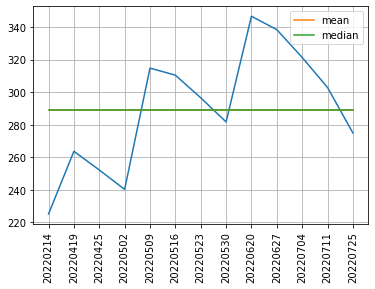

In [75]:
fig,ax = plt.subplots()
bremen_df =dfs[dfs.KRS==('Jena')] 
timeline = ax.plot(bremen_df['date'],bremen_df['halte.ges.SFL'])
y_mean = [bremen_df['halte.ges.SFL'].mean()]*len(bremen_df)
y_med= [bremen_df['halte.ges.SFL'].median()]*len(bremen_df)
mean_line = ax.plot(bremen_df.date, y_mean, label='mean')
med_line = ax.plot(bremen_df.date, y_med, label='median')

plt.xticks(rotation=90)

# Make a legend
legend = ax.legend(loc='upper right')
ax.grid()
fig.show()

<AxesSubplot:xlabel='date'>

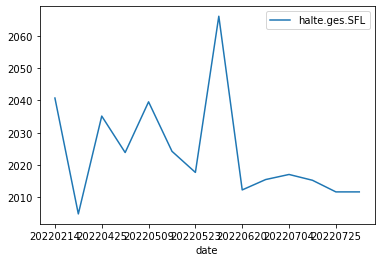

In [76]:
dfs[dfs.KRS.str.contains('Stuttgart')].plot('date','halte.ges.SFL')

Gibt es Ausreißer nach oben?

In [77]:
maxs = dfs.drop(['KRS','date'],axis=1).groupby('AGS').max()

/tmp/ipykernel_211439/3689511904.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  maxs = dfs.drop(['KRS','date'],axis=1).groupby('AGS').max()


In [78]:
means = dfs.groupby('AGS').mean()

In [79]:
maxdiffs = ((maxs - means)/means).sort_values('halte.ges.SFL').merge(kreise, on='AGS')

In [80]:
maxdiffs

,AGS,EWZ_x,KFL_x,SFL_x,halte.ges,halte.fz,halte.fb,halte.nv,halte.ges.EWZ,halte.ges.SFL,...,halte.fz.SFL,halte.fb.EWZ,halte.fb.SFL,halte.nv.EWZ,halte.nv.SFL,KRS,EWZ_y,KFL_y,SFL_y,geometry
0,6633,0.0,0.0,0.000000e+00,0.003620,NaN,0.218370,0.003673,0.003620,0.003620,...,NaN,0.218370,0.218370,0.003673,0.003673,Kassel,236764,1293.31,182.35671,"MULTIPOLYGON (((9.70383 51.26369, 9.70244 51.2..."
1,6434,0.0,0.0,0.000000e+00,0.003723,NaN,NaN,0.003723,0.003723,0.003723,...,NaN,NaN,NaN,0.003723,0.003723,Hochtaunuskreis,236914,481.84,95.88616,"POLYGON ((8.47022 50.41069, 8.47157 50.41054, ..."
2,3402,0.0,0.0,1.137577e-16,0.003955,0.001639,0.132408,0.003953,0.003955,0.003955,...,0.001639,0.132408,0.132408,0.003953,0.003953,Emden,49913,112.34,31.23052,"POLYGON ((7.27544 53.40561, 7.27588 53.40491, ..."
3,12053,0.0,0.0,0.000000e+00,0.004166,0.000796,0.105771,0.004569,0.004166,0.004166,...,0.000796,0.105771,0.105771,0.004569,0.004569,Frankfurt (Oder),57751,147.85,35.33615,"POLYGON ((14.47695 52.39794, 14.47712 52.39571..."
4,1058,0.0,0.0,1.158862e-16,0.004400,0.047896,0.460148,0.004437,0.004400,0.004400,...,0.047896,0.460148,0.460148,0.004437,0.004437,Rendsburg-Eckernförde,274098,2189.78,245.25536,"POLYGON ((9.97017 54.64701, 9.97222 54.64665, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,5566,0.0,0.0,1.778318e-16,0.801123,0.001838,0.245037,0.802115,0.801123,0.801123,...,0.001838,0.245037,0.245037,0.802115,0.802115,Steinfurt,448220,1795.77,319.64706,"POLYGON ((7.60898 52.47399, 7.61059 52.47245, ..."
397,3102,0.0,0.0,0.000000e+00,0.897813,NaN,NaN,0.897813,0.897813,0.897813,...,NaN,NaN,NaN,0.897813,0.897813,Salzgitter,104291,224.49,63.30618,"POLYGON ((10.41082 52.21950, 10.41088 52.21936..."
398,5370,0.0,0.0,0.000000e+00,0.941143,0.036175,NaN,0.941759,0.941143,0.941143,...,0.036175,NaN,NaN,0.941759,0.941759,Heinsberg,255555,627.92,143.16576,"POLYGON ((6.25684 51.18758, 6.25914 51.18695, ..."
399,9171,0.0,0.0,0.000000e+00,1.010217,NaN,NaN,1.010217,1.010217,1.010217,...,NaN,NaN,NaN,1.010217,1.010217,Altötting,111516,569.29,75.14628,"POLYGON ((12.61980 48.35606, 12.61941 48.35341..."


In [81]:
bigdiffs = maxdiffs.loc[maxdiffs['halte.ges.SFL'].abs()>0.5,['AGS']
    ].merge(dfs, on='AGS')
bigdiffs.loc[:,'date'] = pd.to_datetime(bigdiffs.date)

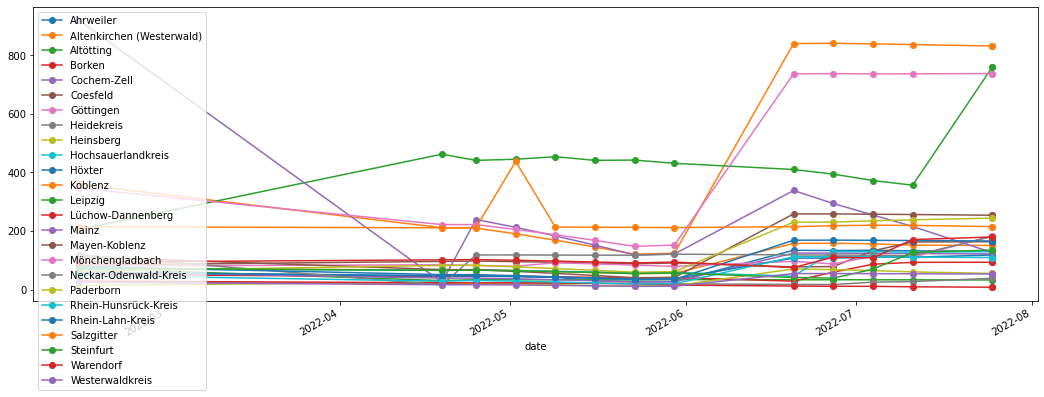

In [82]:
fig, ax = plt.subplots(figsize=(18,6))

for name, group in bigdiffs.groupby('KRS'):
    # x_end = max(group['date'])
    # y_end = group.loc[group.date==x_end,'halte.ges.SFL']
    group.plot(x='date', y='halte.ges.SFL', marker="o", ax=ax, label=name)
    # Add country text
    # ax.text(
    #     x_end, 
    #     y_end, 
    #     name, 
    #     # color=color, 
    #     fontsize=14, 
    #     # weight="bold", 
    #     # fontfamily="Montserrat", 
    #     va="center"
    # )
    
    
plt.show()

POI: Leipzig peaks in most recent download, but no agencies that weren't there before.

It seems like a) excluding the Feb dataset, then taking max of moving average with windo size 3-4 or so would be reasonable. Ideally moving median, to exclude individual highs that are not surrounded by other high points. i.e. max (moving median over 3)

In [83]:
roll_med_max = dfs.drop(['geometry','EWZ','KFL','SFL'],axis=1
    ).loc[:,'AGS':'date'
    ].sort_values(['AGS','date']
    ).groupby('AGS'
    ).rolling(3).median(
    ).groupby('AGS'
    ).max(
    ).drop('date',axis=1
    ).merge(kreise, on='AGS')

In [84]:
roll_med_max[roll_med_max.KRS=='Koblenz']

,AGS,halte.ges,halte.fz,halte.fb,halte.nv,halte.ges.EWZ,halte.ges.SFL,halte.fz.EWZ,halte.fz.SFL,halte.fb.EWZ,halte.fb.SFL,halte.nv.EWZ,halte.nv.SFL,KRS,EWZ,KFL,SFL,geometry
142,7111,32179.433155,43.851695,7.305556,32129.673797,0.282147,839.952837,0.000384,1.144624,0.000064,0.190691,0.281711,838.654011,Koblenz,114052,105.25,38.311,"POLYGON ((7.61181 50.38440, 7.61333 50.38271, ..."


/tmp/ipykernel_211439/1415189519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[:,'date'] = pd.to_datetime(plot_df.date)


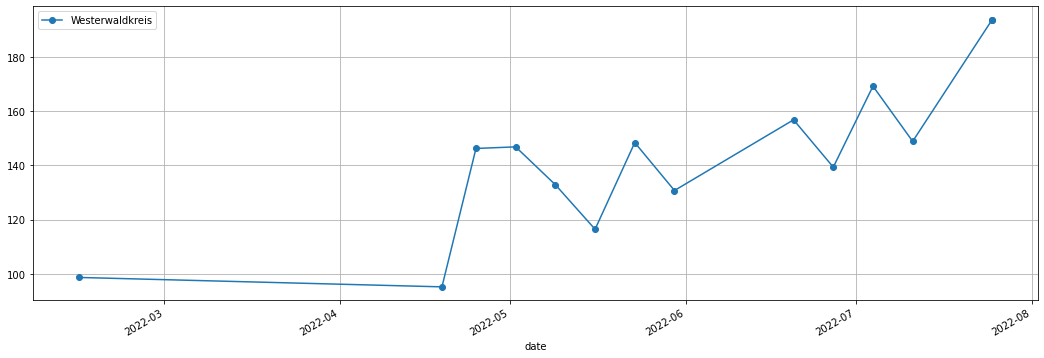

In [85]:
plot_df = dfs.loc[dfs.KRS=='Magdeburg',:]
plot_df.loc[:,'date'] = pd.to_datetime(plot_df.date)

fig, ax = plt.subplots(figsize=(18,6))

plot_df.plot(x='date', y='halte.ges.SFL', marker="o", ax=ax, label=name)
    
ax.grid()   
plt.show()

Serialize.

In [86]:
datadir = '../../data/processed/'

In [32]:
# Timestamp für Versionierung
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
print("Timestamp:\t{}".format(timestamp))

Timestamp:	20220801-115346


KRS

In [88]:
filenames = [s for s in os.listdir(datadir) if re.search('KRS.geojson',s)]
dates = [re.search('\d{8}',s)[0] for s in filenames]
# load all datasets
dfs = pd.concat([pd.DataFrame(gpd.read_file(datadir + s)).assign(date=d) for s,d in zip(filenames,dates)])
kreise = dfs[['AGS','KRS','EWZ','KFL','SFL','geometry']].drop_duplicates('AGS')
# smush them together--with window-3 rolling median
roll_med_max = dfs.drop(['geometry','EWZ','KFL','SFL'],axis=1
    ).loc[:,'AGS':'date'
    ].sort_values(['AGS','date']
    ).groupby('AGS'
    ).rolling(3).median(
    ).groupby('AGS'
    ).max(
    ).drop('date',axis=1
    ).merge(kreise, on='AGS')

gpd.GeoDataFrame(
    roll_med_max[['KRS', 'AGS', 'EWZ', 'KFL', 'SFL', 'halte.ges', 'halte.fz', 'halte.fb',
       'halte.nv', 'halte.ges.EWZ', 'halte.ges.SFL', 'halte.fz.EWZ',
       'halte.fz.SFL', 'halte.fb.EWZ', 'halte.fb.SFL', 'halte.nv.EWZ',
       'halte.nv.SFL', 'geometry']
            ]
).to_file(datadir + timestamp + '_3-med.KRS.geojson',driver="GeoJSON")

/home/jupyter-maita.schade/.conda/envs/oev-atlas/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


GEM

In [89]:
filenames = [s for s in os.listdir(datadir) if re.search('GEM.geojson',s)]
dates = [re.search('\d{8}',s)[0] for s in filenames]
# load all datasets
dfs = pd.concat([pd.DataFrame(gpd.read_file(datadir + s)).assign(date=d) for s,d in zip(filenames,dates)])
gemeinden = dfs[['AGS','GEM','EWZ','KFL','SFL','geometry']].drop_duplicates('AGS')
# smush them together--with window-3 rolling median
roll_med_max = dfs.drop(['geometry','EWZ','KFL','SFL'],axis=1
    ).loc[:,'AGS':'date'
    ].sort_values(['AGS','date']
    ).groupby('AGS'
    ).rolling(3).median(
    ).groupby('AGS'
    ).max(
    ).drop('date',axis=1
    ).merge(gemeinden, on='AGS')

gpd.GeoDataFrame(
    roll_med_max[['GEM', 'AGS', 'EWZ', 'KFL', 'SFL', 'halte.ges', 'halte.fz', 'halte.fb',
       'halte.nv', 'halte.ges.EWZ', 'halte.ges.SFL', 'halte.fz.EWZ',
       'halte.fz.SFL', 'halte.fb.EWZ', 'halte.fb.SFL', 'halte.nv.EWZ',
       'halte.nv.SFL', 'geometry']
            ]
).to_file(datadir + timestamp + '_3-med.GEM.geojson',driver="GeoJSON")

/home/jupyter-maita.schade/.conda/envs/oev-atlas/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


5k

In [97]:
filenames = [s for s in os.listdir(datadir) if re.search('_5k.geojson',s)]
dates = [re.search('\d{8}',s)[0] for s in filenames]
# load all datasets
dfs = pd.concat([pd.DataFrame(gpd.read_file(datadir + s)).assign(date=d) for s,d in zip(filenames,dates)])
grid = dfs[['index','geometry']].drop_duplicates('index')
# smush them together--with window-3 rolling median
roll_med_max = dfs.drop(['geometry'],axis=1
    ).fillna(0
    ).sort_values(['index','date']
    ).groupby('index'
    ).rolling(3).median(
    ).groupby('index'
    ).max(
    ).drop('date',axis=1
    ).merge(grid, on='index'
    ).rename(columns={'n.fz':'halte.fz', 'n.fb':'halte.fb', 'n.nv':'halte.nv', 'n.ges':'halte.ges'})

gpd.GeoDataFrame(
    roll_med_max[['index','halte.fz','halte.fb','halte.nv','halte.ges','geometry']
                ]
).to_file(datadir + timestamp + '_3-med.5k.geojson',driver="GeoJSON")

1k

In [101]:
filenames = [s for s in os.listdir(datadir) if re.search('_1k.geojson',s)]
dates = [re.search('\d{8}',s)[0] for s in filenames]
# load all datasets
dfs = pd.concat([pd.DataFrame(gpd.read_file(datadir + s)).assign(date=d) for s,d in zip(filenames,dates)])
grid = dfs[['index','geometry']].drop_duplicates('index')
# smush them together--with window-3 rolling median
roll_med_max = dfs.drop(['geometry'],axis=1
    ).fillna(0
    ).sort_values(['index','date']
    ).groupby('index'
    ).rolling(3).median(
    ).groupby('index'
    ).max(
    ).drop('date',axis=1
    ).merge(grid, on='index'
    ).rename(columns={'n.fz':'halte.fz', 'n.fb':'halte.fb', 'n.nv':'halte.nv', 'n.ges':'halte.ges'})

gpd.GeoDataFrame(
    roll_med_max[['index','halte.fz','halte.fb','halte.nv','halte.ges','geometry']
            ]
).to_file(datadir + timestamp + '_3-med.1k.geojson',driver="GeoJSON")

/home/jupyter-maita.schade/.conda/envs/oev-atlas/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Haltestellen

In [6]:
interdir = '../../data/interim/'

In [33]:
filenames = [s for s in os.listdir(interdir) if re.search('fb.nstops.csv',s)]
dates = [re.search('\d{8}',s)[0] for s in filenames]
# load all datasets
dfs = pd.concat([pd.read_csv(interdir + s).assign(date=d) for s,d in zip(filenames,dates)])
haltestellen = dfs[['stop_lat','stop_lon','stop_id','stop_name']].drop_duplicates(['stop_lat','stop_lon'])

# smush them together--with window-3 rolling median
roll_med_max = dfs.drop(['Unnamed: 0', 'stop_id', 'stop_name', 'parent_station', 'location_type'],axis=1
    ).sort_values(['stop_lat','stop_lon','date']
    ).groupby(['stop_lat','stop_lon']
    ).rolling(3).median(
    ).groupby(['stop_lat','stop_lon']
    ).max(
    ).drop('date',axis=1
    ).merge(haltestellen, on=['stop_lat','stop_lon'])

roll_med_max[['stop_id', 'stop_name','stop_lat','stop_lon']].to_csv(datadir + timestamp + '_3-med.fb.nstops.csv')

In [34]:
filenames = [s for s in os.listdir(interdir) if re.search('fz.nstops.csv',s)]
dates = [re.search('\d{8}',s)[0] for s in filenames]
# load all datasets
dfs = pd.concat([pd.read_csv(interdir + s).assign(date=d) for s,d in zip(filenames,dates)])
haltestellen = dfs[['stop_lat','stop_lon','stop_id','stop_name']].drop_duplicates(['stop_lat','stop_lon'])

# smush them together--with window-3 rolling median
roll_med_max = dfs.drop(['Unnamed: 0', 'stop_id', 'stop_name', 'parent_station', 'location_type'],axis=1
    ).sort_values(['stop_lat','stop_lon','date']
    ).groupby(['stop_lat','stop_lon']
    ).rolling(3).median(
    ).groupby(['stop_lat','stop_lon']
    ).max(
    ).drop('date',axis=1
    ).merge(haltestellen, on=['stop_lat','stop_lon'])

roll_med_max[['stop_id', 'stop_name','stop_lat','stop_lon']].to_csv(datadir + timestamp + '_3-med.fz.nstops.csv')